In [1]:
!pip install torchinfo
!nvidia-smi

Wed Aug 14 10:24:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo
import os
from pytz import timezone
from tqdm import tqdm


# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)  # 출력결과: cuda

if DEVICE.type == "cuda":
    print("Count of using GPUs:", torch.cuda.device_count())
    print("Current cuda device:", torch.cuda.current_device())
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")

    print("Memory Cached:", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Device: cuda
Count of using GPUs: 1
Current cuda device: 0
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB


In [26]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0001
MOMENTUM = 0.9
BATCH_SIZE = 128
EPOCHS = 60
IMG_SIZE = 32
NUM_CLASSES = 10

In [27]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [28]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [29]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [30]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [31]:
def training_loop(
    model,
    criterion,
    optimizer,
    lr_scheduler,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):
    train_losses = []
    valid_losses = []
    print(
        datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
        "--- Start Training Loop ---",
    )

    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False
        )
        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        running_loss = 0.0
        valid_loader_tqdm = tqdm(
            valid_loader, desc=f"Validation {epoch + 1}/{epochs}", leave=False
        )
        with torch.no_grad():
            for inputs, labels in valid_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        valid_loss = running_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch + 1}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

        lr_scheduler.step(valid_acc)

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [32]:
class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=False):
        super(BottleneckResidualBlock, self).__init__()
        o1, o2, o3 = out_channels
        self.conv1 = nn.Conv2d(
            in_channels, o1, kernel_size=1, stride=stride, bias=False
        )
        self.bn1 = nn.BatchNorm2d(o1)
        self.conv2 = nn.Conv2d(o1, o2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(o2)
        self.conv3 = nn.Conv2d(o2, o3, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(o3)

        if downsample:
            self.downsample = nn.Conv2d(in_channels, o3, kernel_size=1, stride=stride, bias=False)
            self.bn_downsample = nn.BatchNorm2d(o3)
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.downsample:
            identity = self.bn_downsample(self.downsample(identity))
        x = F.relu(x + identity)
        return x


class ResNet50Conv2_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv2_x, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_a = BottleneckResidualBlock(
            64, [64, 64, 256], stride=1, downsample=True
        )
        self.conv2_b = BottleneckResidualBlock(256, [64, 64, 256], stride=1)
        self.conv2_c = BottleneckResidualBlock(256, [64, 64, 256], stride=1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv2_a(x)
        x = self.conv2_b(x)
        x = self.conv2_c(x)
        return x


class ResNet50Conv3_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv3_x, self).__init__()
        self.conv3_a = BottleneckResidualBlock(
            256, [128, 128, 512], stride=2, downsample=True
        )
        self.conv3_b = BottleneckResidualBlock(512, [128, 128, 512], stride=1)
        self.conv3_c = BottleneckResidualBlock(512, [128, 128, 512], stride=1)
        self.conv3_d = BottleneckResidualBlock(512, [128, 128, 512], stride=1)

    def forward(self, x):
        x = self.conv3_a(x)
        x = self.conv3_b(x)
        x = self.conv3_c(x)
        x = self.conv3_d(x)
        return x


class ResNet50Conv4_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv4_x, self).__init__()
        self.conv4_a = BottleneckResidualBlock(
            512, [256, 256, 1024], stride=2, downsample=True
        )
        self.conv4_b = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_c = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_d = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_e = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)
        self.conv4_f = BottleneckResidualBlock(1024, [256, 256, 1024], stride=1)

    def forward(self, x):
        x = self.conv4_a(x)
        x = self.conv4_b(x)
        x = self.conv4_c(x)
        x = self.conv4_d(x)
        x = self.conv4_e(x)
        x = self.conv4_f(x)
        return x


class ResNet50Conv5_x(nn.Module):
    def __init__(self):
        super(ResNet50Conv5_x, self).__init__()
        self.conv5_a = BottleneckResidualBlock(
            1024, [512, 512, 2048], stride=2, downsample=True
        )
        self.conv5_b = BottleneckResidualBlock(2048, [512, 512, 2048], stride=1)
        self.conv5_c = BottleneckResidualBlock(2048, [512, 512, 2048], stride=1)

    def forward(self, x):
        x = self.conv5_a(x)
        x = self.conv5_b(x)
        x = self.conv5_c(x)
        return x


# ResNet50 모델 정의
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2_x = ResNet50Conv2_x()
        self.conv3_x = ResNet50Conv3_x()
        self.conv4_x = ResNet50Conv4_x()
        self.conv5_x = ResNet50Conv5_x()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


torchinfo.summary(
    ResNet50(),
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    row_settings=["depth", "var_names"],
)

# torchinfo.summary(
#     models.resnet50(pretrained=False),
#     input_size=(1, 3, IMG_SIZE, IMG_SIZE),
# )
# 1000개 클래스 분류에 대해서 학습 파라미터 수가 동일함을 확인

Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
ResNet50 (ResNet50)                                [1, 3, 32, 32]            [1, 10]                   --                        --
├─Conv2d (conv1): 1-1                              [1, 3, 32, 32]            [1, 64, 16, 16]           9,408                     [7, 7]
├─BatchNorm2d (bn1): 1-2                           [1, 64, 16, 16]           [1, 64, 16, 16]           128                       --
├─ResNet50Conv2_x (conv2_x): 1-3                   [1, 64, 16, 16]           [1, 256, 8, 8]            --                        --
│    └─MaxPool2d (pool): 2-1                       [1, 64, 16, 16]           [1, 64, 8, 8]             --                        3
│    └─BottleneckResidualBlock (conv2_a): 2-2      [1, 64, 8, 8]             [1, 256, 8, 8]            --                        --
│    │    └─Conv2d (conv1): 3-1                    [1, 64, 8, 8

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


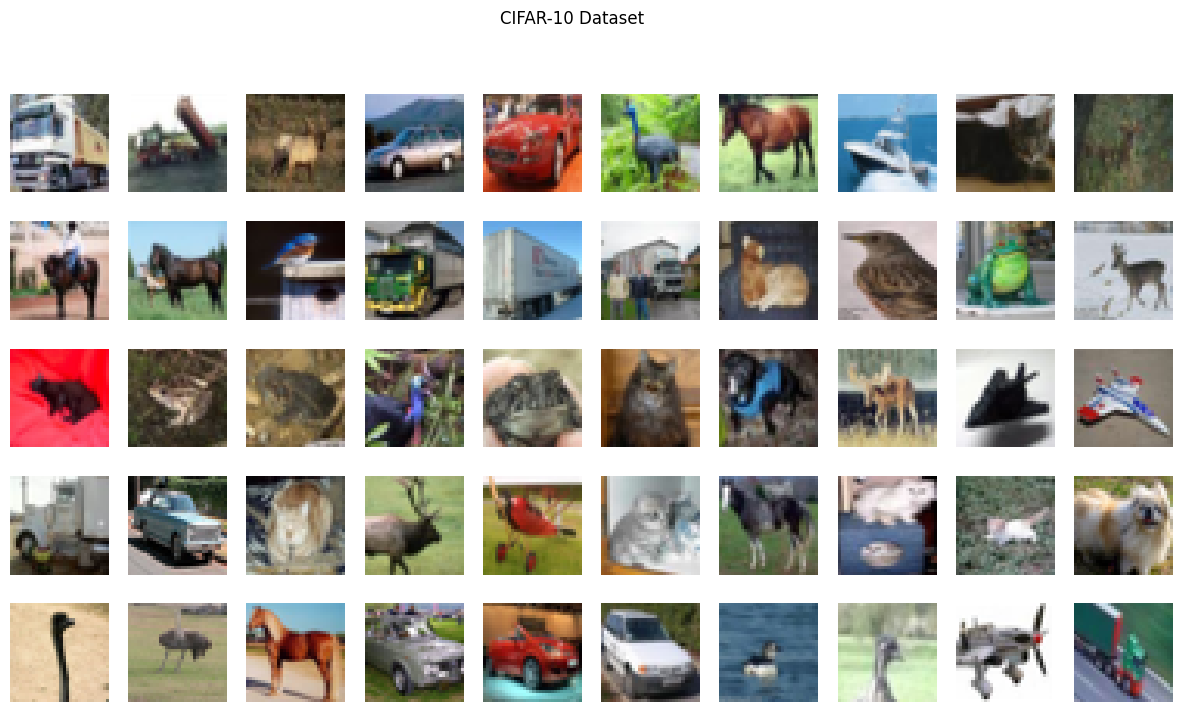

train dataset size:  40000
valid dataset size:  10000
test dataset size:  10000


In [33]:
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
        transforms.ToTensor(),
    ]
)

# 데이터셋 다운로드 및 생성
full_dataset = datasets.CIFAR10(root="cifar10_data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="cifar10_data", train=False, transform=transform)

test_size = len(test_dataset)
valid_size = test_size
train_size = len(full_dataset) - valid_size

train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 불러온 CIFAR-10 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(15, 8))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    img = train_dataset.dataset[index][0]
    img = img.permute(1, 2, 0)  # (채널, 높이, 너비) -> (높이, 너비, 채널)
    plt.imshow(img)

fig.suptitle("CIFAR-10 Dataset")
plt.show()

# 데이터셋 크기 출력
print("train dataset size: ", len(train_dataset))
print("valid dataset size: ", len(valid_dataset))
print("test dataset size: ", len(test_dataset))


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


20:13:22 --- Start Training Loop ---


20:14:01 ---  Epoch: 1	Train loss: 2.5907	Valid loss: 7.9822	Train accuracy: 32.83	Valid accuracy: 32.17


20:14:40 ---  Epoch: 2	Train loss: 2.1746	Valid loss: 9.6248	Train accuracy: 20.57	Valid accuracy: 19.97


20:15:19 ---  Epoch: 3	Train loss: 2.1661	Valid loss: 3.1182	Train accuracy: 30.87	Valid accuracy: 29.85


20:15:58 ---  Epoch: 4	Train loss: 1.9036	Valid loss: 2.8491	Train accuracy: 42.44	Valid accuracy: 42.19


20:16:38 ---  Epoch: 5	Train loss: 1.8815	Valid loss: 2.2653	Train accuracy: 45.95	Valid accuracy: 44.24


20:17:17 ---  Epoch: 6	Train loss: 1.8110	Valid loss: 2.5320	Train accuracy: 45.69	Valid accuracy: 44.38


20:17:57 ---  Epoch: 7	Train loss: 1.6477	Valid loss: 1.8119	Train accuracy: 50.03	Valid accuracy: 47.88


20:18:36 ---  Epoch: 8	Train loss: 1.5393	Valid loss: 2.0942	Train accuracy: 48.87	Valid accuracy: 47.59


20:19:16 ---  Epoch: 9	Train loss: 1.5010	Valid loss: 2.2000	Train accuracy: 53.88	Valid accuracy: 51.15


20:19:55 ---  Epoch: 10	Train loss: 1.4211	Valid loss: 6.0202	Train accuracy: 56.54	Valid accuracy: 54.08


20:20:35 ---  Epoch: 11	Train loss: 1.4684	Valid loss: 10.3240	Train accuracy: 49.72	Valid accuracy: 46.99


20:21:14 ---  Epoch: 12	Train loss: 1.4987	Valid loss: 1.6675	Train accuracy: 54.76	Valid accuracy: 51.72


20:21:53 ---  Epoch: 13	Train loss: 1.3684	Valid loss: 1.9160	Train accuracy: 58.20	Valid accuracy: 54.83


20:22:32 ---  Epoch: 14	Train loss: 1.2867	Valid loss: 2.1323	Train accuracy: 62.18	Valid accuracy: 58.27


20:23:12 ---  Epoch: 15	Train loss: 1.2239	Valid loss: 4.1206	Train accuracy: 41.98	Valid accuracy: 40.11


20:23:57 ---  Epoch: 16	Train loss: 1.2107	Valid loss: 1.3008	Train accuracy: 63.59	Valid accuracy: 59.66


20:24:45 ---  Epoch: 17	Train loss: 1.1478	Valid loss: 1.6360	Train accuracy: 66.06	Valid accuracy: 60.43


20:25:35 ---  Epoch: 18	Train loss: 1.3665	Valid loss: 7.1488	Train accuracy: 41.03	Valid accuracy: 39.68


20:26:16 ---  Epoch: 19	Train loss: 1.3754	Valid loss: 4.5867	Train accuracy: 60.92	Valid accuracy: 57.08


20:26:55 ---  Epoch: 20	Train loss: 1.3349	Valid loss: 9.3495	Train accuracy: 47.78	Valid accuracy: 45.77


20:27:34 ---  Epoch: 21	Train loss: 1.3487	Valid loss: 3.1168	Train accuracy: 61.36	Valid accuracy: 56.69


20:28:13 ---  Epoch: 22	Train loss: 1.0499	Valid loss: 1.1959	Train accuracy: 65.83	Valid accuracy: 60.73


20:28:51 ---  Epoch: 23	Train loss: 0.9866	Valid loss: 1.3374	Train accuracy: 66.36	Valid accuracy: 60.12


20:29:30 ---  Epoch: 24	Train loss: 0.9645	Valid loss: 1.2125	Train accuracy: 67.35	Valid accuracy: 61.61


20:30:09 ---  Epoch: 25	Train loss: 0.9421	Valid loss: 1.7709	Train accuracy: 67.99	Valid accuracy: 61.12


20:30:48 ---  Epoch: 26	Train loss: 0.9196	Valid loss: 1.3357	Train accuracy: 69.01	Valid accuracy: 61.89


20:31:27 ---  Epoch: 27	Train loss: 0.8995	Valid loss: 1.3388	Train accuracy: 69.85	Valid accuracy: 62.09


20:32:06 ---  Epoch: 28	Train loss: 0.8886	Valid loss: 1.5879	Train accuracy: 70.51	Valid accuracy: 61.84


20:32:45 ---  Epoch: 29	Train loss: 0.8690	Valid loss: 1.3917	Train accuracy: 71.66	Valid accuracy: 62.57


20:33:24 ---  Epoch: 30	Train loss: 0.8501	Valid loss: 1.6436	Train accuracy: 71.74	Valid accuracy: 61.84


20:34:03 ---  Epoch: 31	Train loss: 0.8271	Valid loss: 1.8567	Train accuracy: 72.25	Valid accuracy: 62.70


20:34:42 ---  Epoch: 32	Train loss: 0.8162	Valid loss: 1.3657	Train accuracy: 73.71	Valid accuracy: 62.29


20:35:21 ---  Epoch: 33	Train loss: 0.7991	Valid loss: 1.3628	Train accuracy: 74.12	Valid accuracy: 62.90


20:36:01 ---  Epoch: 34	Train loss: 0.7838	Valid loss: 1.5487	Train accuracy: 75.24	Valid accuracy: 63.32


20:36:40 ---  Epoch: 35	Train loss: 0.7640	Valid loss: 2.7051	Train accuracy: 75.62	Valid accuracy: 62.88


20:37:19 ---  Epoch: 36	Train loss: 0.7391	Valid loss: 1.6718	Train accuracy: 76.74	Valid accuracy: 63.06


20:37:59 ---  Epoch: 37	Train loss: 0.7254	Valid loss: 2.8474	Train accuracy: 77.08	Valid accuracy: 62.46


20:38:39 ---  Epoch: 38	Train loss: 0.7043	Valid loss: 2.3605	Train accuracy: 78.40	Valid accuracy: 62.92


20:39:18 ---  Epoch: 39	Train loss: 0.6396	Valid loss: 1.3960	Train accuracy: 79.99	Valid accuracy: 63.67


20:39:57 ---  Epoch: 40	Train loss: 0.6204	Valid loss: 1.9516	Train accuracy: 80.24	Valid accuracy: 63.77


20:40:37 ---  Epoch: 41	Train loss: 0.6141	Valid loss: 2.2224	Train accuracy: 80.64	Valid accuracy: 63.93


20:41:16 ---  Epoch: 42	Train loss: 0.6057	Valid loss: 1.9718	Train accuracy: 80.64	Valid accuracy: 63.70


20:41:55 ---  Epoch: 43	Train loss: 0.6019	Valid loss: 5.1646	Train accuracy: 80.58	Valid accuracy: 63.42


20:42:34 ---  Epoch: 44	Train loss: 0.5993	Valid loss: 3.1537	Train accuracy: 81.26	Valid accuracy: 63.76


20:43:12 ---  Epoch: 45	Train loss: 0.5933	Valid loss: 1.9935	Train accuracy: 81.63	Valid accuracy: 63.75


20:43:51 ---  Epoch: 46	Train loss: 0.5834	Valid loss: 3.3186	Train accuracy: 81.40	Valid accuracy: 63.30


20:44:29 ---  Epoch: 47	Train loss: 0.5820	Valid loss: 3.5761	Train accuracy: 81.68	Valid accuracy: 63.74


20:45:08 ---  Epoch: 48	Train loss: 0.5750	Valid loss: 4.0059	Train accuracy: 81.54	Valid accuracy: 63.48


20:45:47 ---  Epoch: 49	Train loss: 0.5807	Valid loss: 3.9599	Train accuracy: 81.14	Valid accuracy: 63.40


20:46:25 ---  Epoch: 50	Train loss: 0.5770	Valid loss: 2.9356	Train accuracy: 81.72	Valid accuracy: 63.61


20:47:04 ---  Epoch: 51	Train loss: 0.5789	Valid loss: 3.1143	Train accuracy: 81.48	Valid accuracy: 63.88


20:47:42 ---  Epoch: 52	Train loss: 0.5803	Valid loss: 6.3125	Train accuracy: 81.54	Valid accuracy: 62.69


20:48:21 ---  Epoch: 53	Train loss: 0.5793	Valid loss: 3.4096	Train accuracy: 81.69	Valid accuracy: 63.46


20:48:59 ---  Epoch: 54	Train loss: 0.5791	Valid loss: 3.0987	Train accuracy: 81.74	Valid accuracy: 63.39


20:49:37 ---  Epoch: 55	Train loss: 0.5804	Valid loss: 1.3118	Train accuracy: 81.99	Valid accuracy: 63.97


20:50:15 ---  Epoch: 56	Train loss: 0.5758	Valid loss: 3.3074	Train accuracy: 81.84	Valid accuracy: 63.56


20:50:54 ---  Epoch: 57	Train loss: 0.5748	Valid loss: 2.7875	Train accuracy: 81.82	Valid accuracy: 63.32


20:51:32 ---  Epoch: 58	Train loss: 0.5713	Valid loss: 5.7330	Train accuracy: 81.21	Valid accuracy: 63.01


20:52:10 ---  Epoch: 59	Train loss: 0.5763	Valid loss: 3.0467	Train accuracy: 81.85	Valid accuracy: 63.37


20:52:48 ---  Epoch: 60	Train loss: 0.5800	Valid loss: 2.3514	Train accuracy: 81.75	Valid accuracy: 63.38


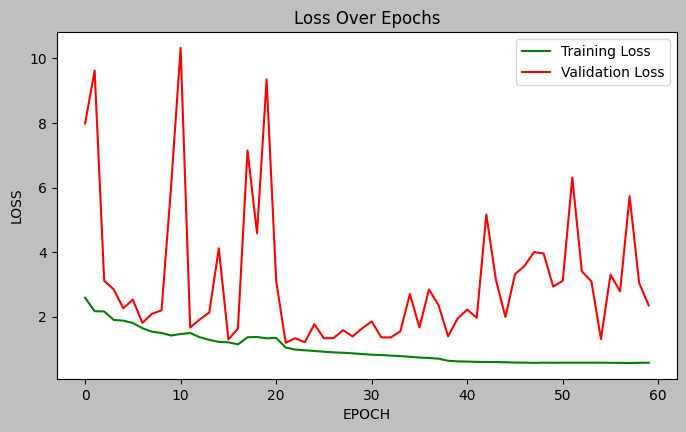

In [34]:
torch.manual_seed(RANDOM_SEED)

_model = ResNet50().cuda()
model = nn.DataParallel(_model).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, lr_scheduler, train_loader, valid_loader, EPOCHS, DEVICE
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 2.7485, Test Accuracy: 0.6365


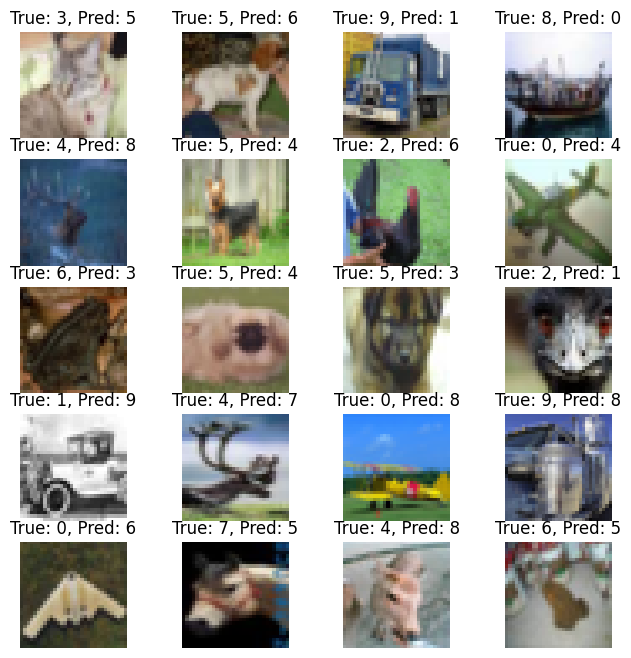

In [35]:
import matplotlib.pyplot as plt

# 테스트 데이터셋을 사용하여 모델의 성능을 평가하고 틀린 예시를 저장
def test_and_collect_mistakes(test_loader, model, criterion, device):
    model.eval()  # 평가 모드로 전환
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    mistakes = []

    with torch.no_grad():  # 평가시에는 그래디언트 계산 불필요
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # 순전파와 손실 기록하기
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)

            # 예측 및 정확도 계산
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 틀린 예시 저장
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    mistakes.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

    epoch_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return epoch_loss, accuracy, all_preds, all_labels, mistakes

# 모델 학습이 완료된 후 평가 수행
test_loss, test_accuracy, test_preds, test_labels, mistakes = test_and_collect_mistakes(test_loader, model, criterion, DEVICE)

# 틀린 예시 시각화
def plot_mistakes(mistakes, num_examples=20):
    plt.figure(figsize=(8, 8))
    for i, (image, true_label, pred_label) in enumerate(mistakes[:num_examples]):
        plt.subplot(5, 4, i + 1)
        plt.axis('off')
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.show()

# 틀린 예시 출력
plot_mistakes(mistakes)
